## Task 2 - Mainly ML

## Data Preprocessing
> 1. Data exploration - Load the data and find missing values, null values
> 2. Performing text cleaning steps like converting to lowercase, remove punctuation, stopwords
> 3. Tokenization of the above processed text
> 4. Encoding the categorical labels into the required format.

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

import torch
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertForSequenceClassification, enable_full_determinism, AutoTokenizer
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding



In [183]:
import warnings
warnings.filterwarnings("ignore")

In [184]:
seed = 7
set_random_seed(seed)

In [185]:
dataset = pd.read_csv('Problem_Dataset.csv').copy() # creating a deep copy of the original dataset

In [186]:
dataset.info()
dataset.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sID     1050 non-null   int64 
 1   Obs     1050 non-null   object
 2   Type    1050 non-null   object
 3   A1      1050 non-null   int64 
 4   A2      1050 non-null   int64 
 5   A3      1050 non-null   int64 
 6   B1      1050 non-null   int64 
 7   B2      1050 non-null   int64 
 8   B3      1050 non-null   int64 
 9   B4      1050 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 82.2+ KB


,sID,Obs,Type,A1,A2,A3,B1,B2,B3,B4
0,150668,Observed child fixated on a particular texture...,B3,0,0,0,0,0,1,0
1,150409,"Patient's focus centers on vacuum cleaners, st...",B3,0,0,0,0,0,1,0
2,150264,Displays a strong interest in smelling various...,B4,0,0,0,0,0,0,1
3,150373,Patient's attachment to a specific book is evi...,B3,0,0,0,0,0,1,0
4,150343,"Limited awareness of personal boundaries, inva...",A3,0,0,1,0,0,0,0
5,150249,"Repeatedly opens and closes doors, seemingly f...",B1,0,0,0,1,0,0,0
6,150183,Engages in repetitive smelling and touching of...,B4,0,0,0,0,0,0,1
7,150982,Has difficulties in understanding social cues ...,A3,0,0,1,0,0,0,0
8,150640,Demonstrates a need to perform certain actions...,B2,0,0,0,0,1,0,0
9,150290,Engages in repetitive touching of textured sur...,B1,0,0,0,1,0,0,0


**There are no null values in the dataset.**

categories = ['B3' 'B4' 'A3' 'B1' 'B2' 'A1' 'A2']


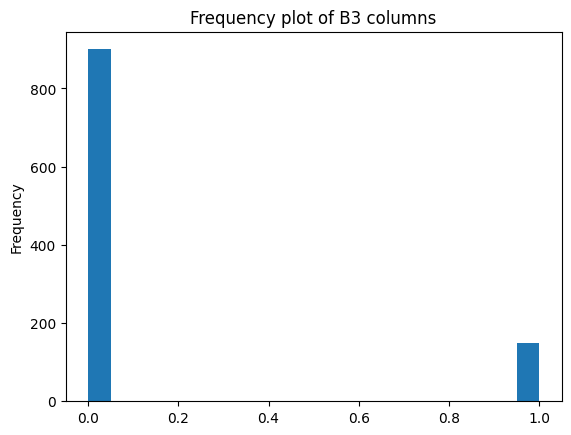

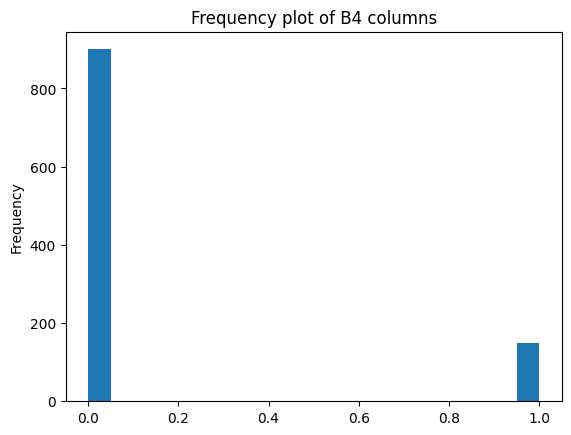

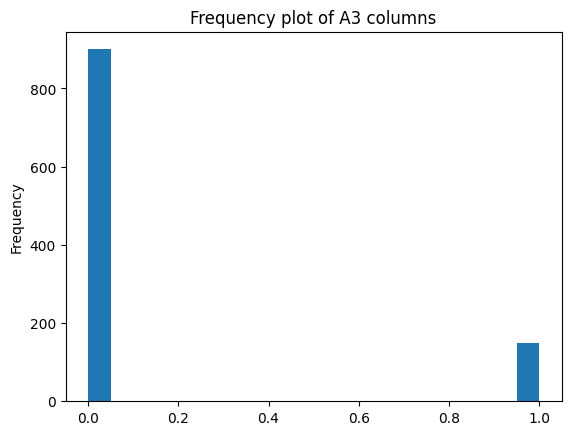

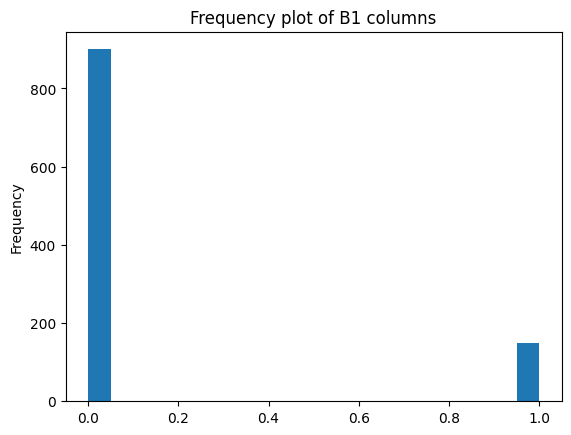

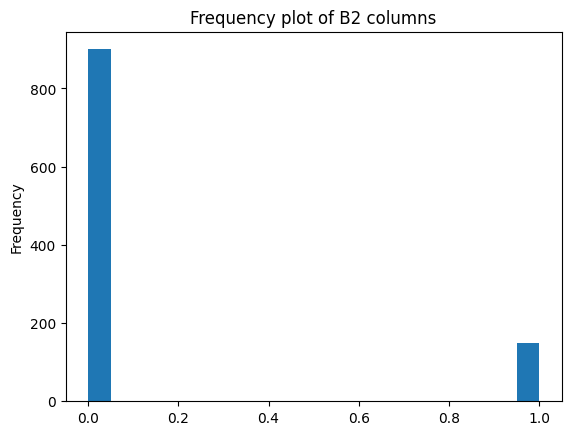

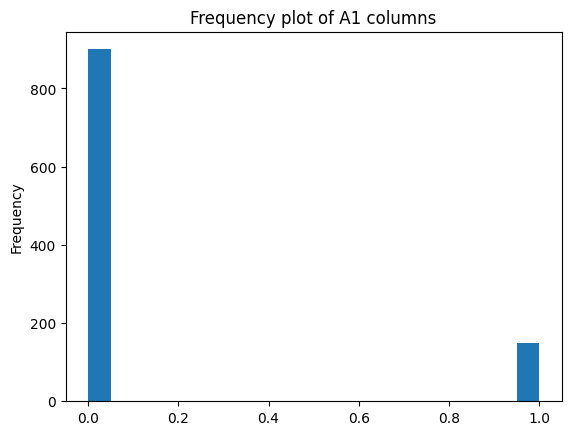

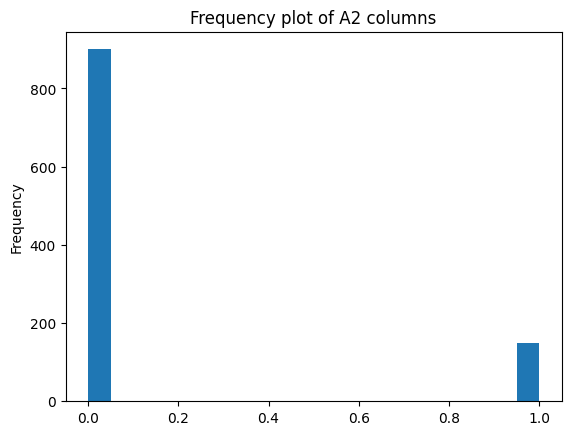

In [187]:
# Plotting the histogram for each type to understand the distribution
def get_frequency_dist(categories):
  for category in list(categories):
    dataset[category].plot(kind='hist', bins=20, title=f'Frequency plot of {category} columns')
    plt.show()

categories = dataset['Type'].unique()
print("categories =",categories)
get_frequency_dist(categories)

**The dataset is imbalanced and biased towards the negative class for each Type since it has more 0 for each type.**

In [188]:
class CleanAndPreprocess:
    '''
    Class for pre-processing the dataset into required format

    Methods:
        preprocess_text(each_obs): Preprocesses a single observation.
        get_preprocessed_text(): Preprocess the entire dataset and returns the updated dataset with preprocessed text.
        get_padded_sequences(): Tokenizes the preprocessed text, converts it to sequences, and pads the sequences to uniform length.
        get_tokenizer(): Returns the fitted tokenizer.

    Attributes:
    
        dataset(pd.DataFrame): The dataset given
        column(str): The column containing the text data 
        max_vocab_size(int): The maximum number of words to be included in the vocabulary of the tokenizer.
        tokenizer(keras.preprocessing.text.Tokenizer): The tokenizer used
        max_length(int): The maximum length of the sequences after padding. It is set after fitting the tokenizer.
        padded_sequences(np.ndarray): The padded sequences of the text data. It is set after calling `get_padded_sequences()`.

    '''
    def __init__(self, dataset=dataset, column = 'Obs', max_vocab_size=10000):
        '''
         Args:
             dataset(pd.DataFrame): the dataset
             column: The column containing the text data. Default is 'Obs'
             max_vocab_size(int): The maximum number of words to be included 
             in the vocabulary of the tokenizer. Default is 10000    
        '''
        self.dataset = dataset
        self.column = column
        self.max_vocab_size = 10000
        self.tokenizer = None
        self.max_length = None
        self.padded_sequences = None
    
    def preprocess_text(self, each_obs):
        '''
          Pre-processes the text by converting to lowercase, removing digits and 
          special characters and removing extra whitespaces
    
          Args:
              each_obs: The text data that needs tobe preprocessed
              
          Returns: Returns the pre-processed text
        '''
        each_obs = each_obs.lower() # convert to lowercase
        each_obs = re.sub(r'[^a-z\s]','',each_obs) # remove digits and special chars
        each_obs = re.sub(r'\s+',' ',each_obs).strip() # remove extra whitespaces
        return each_obs
        
    def get_preprocessed_text(self):
        '''
        Applies the preprocessing steps to the entire dataset and adds a new column `processed_text`
        with the cleaned text.

        Returns(pd.DataFrame): Returns the dataset along with a new column called processed_text
        '''
        self.dataset['processed_text'] = self.dataset[self.column].apply(self.preprocess_text)
        return self.dataset
    
    def get_padded_sequences(self):
        '''
        Tokenizes the preprocessed text, converts it to sequences, and pads the sequences to uniform length.

        Returns: The padded sequences of text of type np.ndarray.
        '''
        
        # fit tokenizer
        self.tokenizer = Tokenizer(num_words=self.max_vocab_size)
        self.tokenizer.fit_on_texts(self.dataset['processed_text'])
        # convert text to sequences
        sequences = self.tokenizer.texts_to_sequences(self.dataset['processed_text'])

        # pad sequences to maintain same input size
        # seq length = length of the longest sequence
        self.max_length = max(len(seq) for seq in sequences)
        self.padded_sequences = pad_sequences(sequences, maxlen = self.max_length, padding='post')
        return self.padded_sequences

    def get_tokenizer(self):
        '''
        Returns the fitterd tokenizer of type keras.processing.text.Tokenizer
        '''
        return self.tokenizer




In [175]:
pre_processor = CleanAndPreprocess(dataset, column="Obs")

In [176]:
processed_data = pre_processor.get_preprocessed_text()
processed_data

,sID,Obs,Type,A1,A2,A3,B1,B2,B3,B4,processed_text
0,150668,Observed child fixated on a particular texture...,B3,0,0,0,0,0,1,0,observed child fixated on a particular texture...
1,150409,"Patient's focus centers on vacuum cleaners, st...",B3,0,0,0,0,0,1,0,patients focus centers on vacuum cleaners stud...
2,150264,Displays a strong interest in smelling various...,B4,0,0,0,0,0,0,1,displays a strong interest in smelling various...
3,150373,Patient's attachment to a specific book is evi...,B3,0,0,0,0,0,1,0,patients attachment to a specific book is evid...
4,150343,"Limited awareness of personal boundaries, inva...",A3,0,0,1,0,0,0,0,limited awareness of personal boundaries invad...
...,...,...,...,...,...,...,...,...,...,...,...
1045,150491,Displays a need for consistency in clothing ch...,B2,0,0,0,0,1,0,0,displays a need for consistency in clothing ch...
1046,150884,Patient shows a strong attachment to a single ...,B3,0,0,0,0,0,1,0,patient shows a strong attachment to a single ...
1047,151017,Child displays a tendency to focus on irreleva...,A2,0,1,0,0,0,0,0,child displays a tendency to focus on irreleva...
1048,150297,Displays a tendency to monologue about persona...,A3,0,0,1,0,0,0,0,displays a tendency to monologue about persona...


In [177]:
padded_seq_data = pre_processor.get_padded_sequences()

print(padded_seq_data)
padded_seq_data.shape


[[  42   20  369 ...    0    0    0]
 [ 246   88 1001 ...    0    0    0]
 [  16    5   47 ...    0    0    0]
 ...
 [  20   16    5 ...    0    0    0]
 [  16    5  318 ...    0    0    0]
 [  33    2  442 ...    0    0    0]]


(1050, 26)

In [178]:
dataset[['Obs', 'processed_text']]

,Obs,processed_text
0,Observed child fixated on a particular texture...,observed child fixated on a particular texture...
1,"Patient's focus centers on vacuum cleaners, st...",patients focus centers on vacuum cleaners stud...
2,Displays a strong interest in smelling various...,displays a strong interest in smelling various...
3,Patient's attachment to a specific book is evi...,patients attachment to a specific book is evid...
4,"Limited awareness of personal boundaries, inva...",limited awareness of personal boundaries invad...
...,...,...
1045,Displays a need for consistency in clothing ch...,displays a need for consistency in clothing ch...
1046,Patient shows a strong attachment to a single ...,patient shows a strong attachment to a single ...
1047,Child displays a tendency to focus on irreleva...,child displays a tendency to focus on irreleva...
1048,Displays a tendency to monologue about persona...,displays a tendency to monologue about persona...


## Subtask-1 Training Binary Classifiers

## Model Training, Evaluation and Prediction saving

>1. Train deep learning model for each label in [A1, A2, A3, B1,B2,B3,B4]
>2. Use 80:20 train-test split

In [173]:
class BinaryClassifier:

    '''
    class to implement multiple binary classifiers. Trains individual binary classifiers for each label

    Methods:
        prepare_data(label): Splits the data into training and validation sets
        model_builder(vocab_size): Compiles and builds the LSTM model
        train_model(label, X_train, X_val, y_train, y_val, epochs=5, batch_size=32): Trains the model for the given label.
        evaluate_model(label, X_val, y_val): Evaluates the model and calculates the metrics
        run_training_pipeline(epochs=5, batch_size=32): Runs the model and evaluates for all the labels in the dataset.
        preprocess_input(input_text): Preprocesses a new input text for label prediction.
        ensemble_predict(input_text): Predicts the binary labels for a given input text using the ensemble of models.
        evaluate_and_save_predictions(): Evaluates all the models, saves predictions, and generates a metrics report for all the seven labels.

    Attributes:
        pre_processor (object): An object that pre-processes(instantiated at the start) and tokenzies the text
        dataset(pd.DataFrame): The given dataset containing labels, text
        labels(list): Unique labels list from the dataset
        embedding_dim (int): Dimensionality of the embedding layer.
        lstm_units (int): Number of LSTM units used .
        padded_seq_data (np.array): Padded Sequences of input text data.
        models (dict): Dictionary to store trained models for each label.
    
    '''
    
    def __init__(self, pre_processor=pre_processor, labels=['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4'],
                 padded_seq_data=padded_seq_data, dataset=dataset, embedding_dim=128, lstm_units = 128 ):
        '''
        Args:
            pre_processor (object): An object that pre-processes(instantiated at the start) and tokenzies the text
            labels(list): Unique labels list from the dataset.Default is ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4'].
            dataset(pd.DataFrame): The given dataset containing labels, text
            embedding_dim (int): Dimensionality of the embedding layer. Default is 128
            lstm_units (int): Number of LSTM units used. Default is 128
            padded_seq_data (np.array): Padded Sequences of input text data.
            
        '''
        self.pre_processor = pre_processor
        self.dataset = dataset
        self.padded_seq_data = padded_seq_data
        self.labels = labels
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.models = {}

  # preparing data
    def prepare_data(self, label):
        '''
        Args:
            label: The label column in the dataset

        Returns: A tuple containing X_train, X_val, y_train, y_val
        '''
        X = self.padded_seq_data
        y = self.dataset[label].values
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
        return X_train, X_val, y_train, y_val

  # building the model
    def model_builder(self, vocab_size):
        '''
        Args:
            vocab_size(int): Size of the vocabulary in the tokenizer
            
        Returns: The compiled LSTM model of type tf.keras.Model
        '''
        model = Sequential([
            Embedding(input_dim=vocab_size,output_dim=self.embedding_dim, input_length=self.pre_processor.max_length),
            LSTM(self.lstm_units, return_sequences=False),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

  # model training
    def train_model(self, label, X_train, X_val, y_train, y_val, epochs=5, batch_size=32):
        '''
        Args:
            label (str):  The label column in the dataset
            X_train (np.array): Training features.
            X_val (np.array): Validation features.
            y_train (np.array): Training labels.
            y_val (np.array): Validation labels.
            epochs (int, optional): Number of epochs for model training. Default is 5.
            batch_size (int, optional): Batch size used for training. Default is 32.

        '''
        model = self.model_builder(vocab_size=len(self.pre_processor.get_tokenizer().word_index) + 1)
        # model checkpoints to save the model
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=f'./models/{label}_model.keras',
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=1
            )


        trainer = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[checkpoint_callback],
                verbose=1
            )
        self.models[label] = model

    def evaluate_model(self,label,X_val, y_val):
        '''
        Args:
            label: The label column for which the model is being evaluated.
            X_val(np.array): Validation features.
            y_val (np.array): Validation labels.

        Returns: A tuple containing precision, recall, f1 and predicted labels            
        '''

        model = tf.keras.models.load_model(f'./models/{label}_model.keras')
    
        y_pred = (model.predict(X_val)>0.5).astype(int).flatten()
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        return precision, recall, f1, y_pred


    def run_training_pipeline(self, epochs=5, batch_size=32):
        '''
        Args:
            epochs (int, optional): Number of epochs used for training each model. Default is 5.
            batch_size (int, optional): Batch size used for training. Default is 32.
        '''
        metrics = {}
        for label in self.labels:
            print(f"\nTraining model for label: {label}")
            X_train, X_val, y_train, y_val = self.prepare_data(label)
            self.train_model(label, X_train, X_val, y_train, y_val, epochs, batch_size)
            precision, recall, f1, y_pred = self.evaluate_model(label, X_val, y_val)
            metrics[label] = {"Precision": precision, "Recall": recall, "F1-Score": f1}
        print("\nAll model metrics:")
        print(metrics)

    
    def preprocess_input(self, input_text):
        '''
        Args:
            input_text: The input text that needs to be labeled

        Returns: The padded sequence of the preprocessed input text of type np.array.
        '''
        cleaned_text = self.pre_processor.preprocess_text(input_text)
        sequence = self.pre_processor.tokenizer.texts_to_sequences([cleaned_text])
        padded_sequence = pad_sequences(sequence, maxlen=self.pre_processor.max_length, padding='post')
        return padded_sequence

    def ensemble_predict(self, input_text):
        '''
        Args:
            input_text: The input text that needs to be classified

        Returns: Predicted binary labels for each category of type list.
        '''
        processed_input = self.preprocess_input(input_text)
        predictions = []
        for label, model in self.models.items():
          model_path = f'./models/{label}_model.keras'
          model = tf.keras.models.load_model(model_path)
          prediction = (model.predict(processed_input) > 0.5).astype(int).flatten()[0]
          predictions.append(prediction)
        return predictions

    def evaluate_and_save_predictions(self):
        all_predictions = {}
        metrics_report = {}
    
        for label in self.labels:
            print(f"\nEvaluating model for label: {label}")
            X_train, X_val, y_train, y_val = self.prepare_data(label)
            precision, recall, f1, y_pred = self.evaluate_model(label, X_val, y_val)
    
            # Save predictions and metrics for each label
            metrics_report[label] = {
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            }
            all_predictions[label] = y_pred
    
            # Save the predictions and metrics to CSV
            results_df = pd.DataFrame({
                'True Label': y_val,
                'Predicted Label': y_pred
            })
            results_df.to_csv(f'./predictions/{label}_predictions.csv', index=False)
            print(f"Saved {label} predictions to ./predictions/{label}_predictions.csv")
    
        # Save the overall metrics report
        metrics_df = pd.DataFrame(metrics_report).transpose()
        metrics_df.to_csv('ensemble_metrics_report.csv')
        print("Saved overall metrics report to ensemble_metrics_report.csv")







In [14]:
labels = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4']

# Initialize and run the trainer
trainer = BinaryClassifier(pre_processor, labels)
trainer.run_training_pipeline()
trainer.evaluate_and_save_predictions()

# Test the ensemble on a sample input text
sample_text = "This is an example input sentence for testing."
prediction_array = trainer.ensemble_predict(sample_text)

print(f"Predicted labels: {prediction_array}")




Training model for label: A1
Epoch 1/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7672 - loss: 0.5297
Epoch 1: val_loss improved from inf to 0.48227, saving model to ./models/A1_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7779 - loss: 0.5181 - val_accuracy: 0.8333 - val_loss: 0.4823
Epoch 2/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8507 - loss: 0.4277
Epoch 2: val_loss improved from 0.48227 to 0.47566, saving model to ./models/A1_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8525 - loss: 0.4236 - val_accuracy: 0.8333 - val_loss: 0.4757
Epoch 3/5
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8497 - loss: 0.3873
Epoch 3: val_loss improved from 0.47566 to 0.43797, saving model to ./models/A1_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8506 - loss: 0.3824 - val_accuracy: 0.8476 - val_loss: 0.4380
Epoch 4/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9008 - loss: 0.2593
Epoch 4: val_l

/Users/abhay/Desktop/deeptar_nlp/env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8087 - loss: 0.5252
Epoch 1: val_loss improved from inf to 0.42230, saving model to ./models/A2_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8133 - loss: 0.5182 - val_accuracy: 0.8619 - val_loss: 0.4223
Epoch 2/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8677 - loss: 0.4093
Epoch 2: val_loss improved from 0.42230 to 0.41405, saving model to ./models/A2_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8660 - loss: 0.4121 - val_accuracy: 0.8619 - val_loss: 0.4140
Epoch 3/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8677 - loss: 0.3958
Epoch 3: val_loss improved from 0.41405 to 0.39266, saving model to ./models/A2_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8660 - loss: 0.3989 - val_accuracy: 0.8619 - val_loss: 0.3927
Epoch 4/5
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8914 - loss: 0.3242
Epoch 4: val_loss improved from 0.39266 to 0.21454, sa

/Users/abhay/Desktop/deeptar_nlp/env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8513 - loss: 0.5072
Epoch 1: val_loss improved from inf to 0.47273, saving model to ./models/A3_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8519 - loss: 0.5039 - val_accuracy: 0.8238 - val_loss: 0.4727
Epoch 2/5
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8748 - loss: 0.3884
Epoch 2: val_loss improved from 0.47273 to 0.46812, saving model to ./models/A3_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8738 - loss: 0.3906 - val_accuracy: 0.8238 - val_loss: 0.4681
Epoch 3/5
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8745 - loss: 0.3893
Epoch 3: val_loss improved from 0.46812 to 0.45761, saving model to ./models/A3_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8738 - loss: 0.3901 - val_accuracy: 0.8238 - val_loss: 0.4576
Epoch 4/5
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8837 - loss: 0.3377
Epoch 4: val_loss improved from 0.45761 to 0.29675, sa

/Users/abhay/Desktop/deeptar_nlp/env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8320 - loss: 0.5359
Epoch 1: val_loss improved from inf to 0.41318, saving model to ./models/B1_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8346 - loss: 0.5255 - val_accuracy: 0.8619 - val_loss: 0.4132
Epoch 2/5
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8565 - loss: 0.4263
Epoch 2: val_loss improved from 0.41318 to 0.39689, saving model to ./models/B1_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8565 - loss: 0.4259 - val_accuracy: 0.8619 - val_loss: 0.3969
Epoch 3/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8687 - loss: 0.3490
Epoch 3: val_loss improved from 0.39689 to 0.25705, saving model to ./models/B1_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8738 - loss: 0.3355 - val_accuracy: 0.9143 - val_loss: 0.2570
Epoch 4/5
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9796 - loss: 0.0856
Epoch 4: val_loss improved from 0.25705 to 0.16386, sa

/Users/abhay/Desktop/deeptar_nlp/env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7506 - loss: 0.5334
Epoch 1: val_loss improved from inf to 0.32185, saving model to ./models/B2_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7596 - loss: 0.5222 - val_accuracy: 0.8619 - val_loss: 0.3218
Epoch 2/5
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8709 - loss: 0.2833
Epoch 2: val_loss improved from 0.32185 to 0.08012, saving model to ./models/B2_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8763 - loss: 0.2770 - val_accuracy: 0.9810 - val_loss: 0.0801
Epoch 3/5
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9564 - loss: 0.1738
Epoch 3: val_loss improved from 0.08012 to 0.07108, saving model to ./models/B2_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9580 - loss: 0.1688 - val_accuracy: 0.9714 - val_loss: 0.0711
Epoch 4/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9802 - loss: 0.0826
Epoch 4: val_loss did not improve from 0.07108
27/27 ━

/Users/abhay/Desktop/deeptar_nlp/env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8303 - loss: 0.5081
Epoch 1: val_loss improved from inf to 0.39693, saving model to ./models/B3_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8318 - loss: 0.5029 - val_accuracy: 0.8476 - val_loss: 0.3969
Epoch 2/5
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8670 - loss: 0.3428
Epoch 2: val_loss improved from 0.39693 to 0.23082, saving model to ./models/B3_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8701 - loss: 0.3333 - val_accuracy: 0.9333 - val_loss: 0.2308
Epoch 3/5
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9761 - loss: 0.0976
Epoch 3: val_loss improved from 0.23082 to 0.17017, saving model to ./models/B3_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9773 - loss: 0.0930 - val_accuracy: 0.9571 - val_loss: 0.1702
Epoch 4/5
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9897 - loss: 0.0436
Epoch 4: val_loss did not improve from 0.17017
27/27 ━

/Users/abhay/Desktop/deeptar_nlp/env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7556 - loss: 0.5391
Epoch 1: val_loss improved from inf to 0.37325, saving model to ./models/B4_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7624 - loss: 0.5334 - val_accuracy: 0.9095 - val_loss: 0.3732
Epoch 2/5
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8553 - loss: 0.4267
Epoch 2: val_loss improved from 0.37325 to 0.35464, saving model to ./models/B4_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8545 - loss: 0.4275 - val_accuracy: 0.9095 - val_loss: 0.3546
Epoch 3/5
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8780 - loss: 0.3217
Epoch 3: val_loss improved from 0.35464 to 0.10597, saving model to ./models/B4_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8839 - loss: 0.3056 - val_accuracy: 0.9667 - val_loss: 0.1060
Epoch 4/5
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9810 - loss: 0.0601
Epoch 4: val_loss improved from 0.10597 to 0.08027, sa

## Subtask-2 Training MultiLabel classifier and saving predictions

In [181]:
class MultiLableClassifier:
    '''
    This class is constructed to perform multi-label classification using LSTM

    Methods:
        prepare_data(): Splits the data into training and validation sets
        model_builder(vocab_size): Compiles and Builds the LSTM model
        train_model(X_train, X_val, y_train, y_val, epochs=80, batch_size=32): Trains the model based on training and validation or test sets
        evaluate_model(X_val, y_val): Used to evaluate the model on the validation set and saves the metrics and predictions.
        preprocess_input(input_text): Preprocesses the new input text for prediction.
        predict(input_text): Takes a new input text and returns the predicted labels. Can be used to check
        the predicted labels for each text
        
    Attributes:
        pre_processor (object): An object that pre-processes and tokenzies the text
        dataset(pd.DataFrame): The given dataset containing labels, text
        labels(list): Unique labels list from the dataset
        embedding_dim (int): Dimensionality of the embedding layer.
        lstm_units (int): Number of LSTM units used .
        padded_seq_data (np.array):Ppadded sequences of input text data.
        model (tf.keras.Model): LSTM model used for classification.
    '''

    def __init__(self,pre_processor=pre_processor, labels=['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4'],
                embedding_dim=128, lstm_units=128, padded_seq_data=padded_seq_data, dataset=dataset):
        '''
        Initializes the instance of the class with arguments and dataset

        Args:
            pre_processor (object): An object that pre-processes and tokenzies the text
            dataset(pd.DataFrame): The given dataset containing labels, text
            labels(list): Unique labels list from the dataset.  Default is ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4'].
            embedding_dim (int): Dimensionality of the embedding layer. Default is 128.
            lstm_units (int): Number of LSTM units used. Default is 128.
            padded_seq_data (np.array):Padded sequences of input text data. Default is None.
            model (tf.keras.Model): LSTM model used for classification. Default is None
        '''
        self.pre_processor = pre_processor
        self.labels = labels
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.padded_seq_data = padded_seq_data
        self.dataset = dataset
        self.model = None

    
    def prepare_data(self):
        '''
        Returns: A tuple containing training and validation sets.
        '''
        X = self.pre_processor.get_padded_sequences()
        y = self.dataset[self.labels].values
        X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=7)
        return X_train, X_val, y_train, y_val

    def model_builder(self, vocab_size):
        '''
        Args:
            vocab_size(int): Size of the vocabulary
        Returns: 
            The compiled LSTM model of the type tf.keras.Model
        '''
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=self.pre_processor.max_length),
            tf.keras.layers.LSTM(self.lstm_units, return_sequences=False),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(len(self.labels), activation='sigmoid') 
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def train_model(self,X_train, X_val, y_train, y_val, epochs=80, batch_size=32):
        '''
        Args:
            X_train (np.array): Training features.
            X_val (np.array): Validation features.
            y_train (np.array): Training labels or ground truth.
            y_val (numpy.array): Validation labels or ground truth.
            epochs (int, optional): Epochs for training. Default is 80.
            batch_size (int, optional): batch size used. Default is 32.
        '''
        self.model = self.model_builder(vocab_size=len(self.pre_processor.get_tokenizer().word_index) + 1)
        # model checkpoints to save the model
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=f'multi_label_classifier.keras',
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=1
            )


        trainer = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[checkpoint_callback],
                verbose=1
            )

    def evaluate_model(self, X_val, y_val):
        '''
        Args:
            X_val: Validation features
            y_val: Validation labels

        Returns: A dict containing metrics like precision, recall and f1 for each label
        '''
        model_path = 'multi_label_classifier.keras'
        self.model = tf.keras.models.load_model(model_path)
        y_pred = (self.model.predict(X_val) > 0.5).astype(int)

        # Calculate precision, recall, and F1-score for each label and overall
        precision = precision_score(y_val, y_pred, average=None,zero_division=1)
        recall = recall_score(y_val, y_pred, average=None)
        f1 = f1_score(y_val, y_pred, average=None)

        metrics = {
            'Label': self.labels,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }

        # Save metrics and predictions to CSV files
        metrics_df = pd.DataFrame(metrics)
        metrics_df.to_csv('multi_label_metrics_report.csv', index=False)
        print("Saved multi-label metrics report to multi_label_metrics_report.csv")

        predictions_df = pd.DataFrame(y_pred, columns=self.labels)
        predictions_df.to_csv('multi_label_predictions.csv', index=False)
        print("Saved multi-label predictions to multi_label_predictions.csv")
        
        return metrics

    def preprocess_input(self, input_text):
        '''
        Args:
            input_text: input text that needs to be classified
        Returns: Padded sequence of input text of datatype np.array
        '''
        cleaned_text = self.pre_processor.preprocess_text(input_text)
        sequence = self.pre_processor.tokenizer.texts_to_sequences([cleaned_text])
        padded_sequence = pad_sequences(sequence, maxlen=self.pre_processor.max_length, padding='post')
        return padded_sequence

    def predict(self, input_text):
        '''
        Args:
            input_text: text that needs to be labeled
        Returns: Prediced labels for each category of type np.array
        '''
        processed_input = self.preprocess_input(input_text)
        predictions = (self.model.predict(processed_input) > 0.5).astype(int).flatten()
        return predictions
        


In [40]:
trainer = MultiLableClassifier(pre_processor)
X_train, X_val, y_train, y_val = trainer.prepare_data()
trainer.train_model(X_train, X_val, y_train, y_val)

metrics = trainer.evaluate_model(X_val, y_val)

sample_txt = "This is a sample text"
pred_arr = trainer.predict(sample_txt)
print(f"Prediction labels: {pred_arr}")

Epoch 1/80


/Users/abhay/Desktop/deeptar_nlp/env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1594 - loss: 0.5793
Epoch 1: val_loss improved from inf to 0.41912, saving model to multi_label_classifier.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1597 - loss: 0.5735 - val_accuracy: 0.0905 - val_loss: 0.4191
Epoch 2/80
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1633 - loss: 0.4262
Epoch 2: val_loss improved from 0.41912 to 0.41153, saving model to multi_label_classifier.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1628 - loss: 0.4262 - val_accuracy: 0.1381 - val_loss: 0.4115
Epoch 3/80
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1589 - loss: 0.4221
Epoch 3: val_loss improved from 0.41153 to 0.40945, saving model to multi_label_classifier.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1576 - loss: 0.4221 - val_accuracy: 0.1667 - val_loss: 0.4094
Epoch 4/80
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1464 - loss: 0.4243
Epoch 4: val_loss improved from 0.40

## Subtask-3 Finetuning BERT and rerunning the experiment

In [171]:
class MultiLabelBert:
    '''
    MultiLabelBert class is constructed to fine-tune, evaluate and save the BERT
    model. It is used for multi-label text classification task
    
    Methods:
        prepare_data(): Used for creating training and validation(test) sets
        along with tokenization and btach encoding.
        train_model(train_dataset, val_dataset): Trains the BERT model and calculates 
        perdormance on validation set
        eval_save_predictions(val_dataset): Evaluates the model and calculates the metrics
        predict(input_text): Takes a new_input text and outputs the predicted label.
        Can be used to check individual text outputs
    
    Attributes:
        dataset: The given dataset containing labels, text
        labels(list): Unique labels list from the dataset
        column: column with the input text
        max_length: Maximum length for input sequences while tokenizing
        batch_size: batch_size used
        epochs: Number of epochs used
        tokenizer: BERT tokenizer
        model: BERT model for sequence classification   
    '''
    
    def __init__(self, dataset, labels=['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4'],
                 column='Obs', max_length=128, epochs=5, batch_size=32):
        '''
        Initializes the instance of class with dataset and model arguments
    
        Args:
            dataset (pandas.DataFrame): the given dataset containing labels, text
            labels (list, optional): unique labels list from the dataset. Default is ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'B4'].
            column (str, optional): column with the input text. Default is 'Obs'.
            max_length (int, optional): maximum length for input sequences while tokenizing. Default is 128.
            epochs (int, optional): number of epochs used for training the model. Default is 5.
            batch_size (int, optional): batch_size used. Default is 32.
        '''
        self.dataset = dataset
        self.labels = labels
        self.column = column
        self.max_length = max_length
        self.batch_size = batch_size
        self.epochs = epochs
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = TFBertForSequenceClassification.from_pretrained(
            'bert-base-uncased', num_labels=len(self.labels), problem_type="multi_label_classification"
        )

    
    def prepare_data(self):
        '''
        Used for creating training and validation(test) sets along with tokenization and batch encoding.

        Returns: A tuple of tensorflow datasets for training and validation
        '''
        X = self.dataset[self.column].tolist()
        y = self.dataset[self.labels].values.astype(np.float32)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

        def tokenize(texts):
            return self.tokenizer(texts, truncation=True, padding=True, max_length=self.max_length, return_tensors='tf')

        train_encodings = tokenize(X_train)
        val_encodings = tokenize(X_val)

        train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
        val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))

        train_dataset = train_dataset.shuffle(1000).batch(self.batch_size)
        val_dataset = val_dataset.batch(self.batch_size)

        return train_dataset, val_dataset
        
    def train_model(self, train_dataset, val_dataset):
        '''
        Trains the BERT model and calculates performance on validation set

        Arguments:
            train_dataset(tf.data.Dataset): training dataset
            val_dataset(tf.data.Dataset): Validation or test dataset
        '''
        num_train_steps = len(train_dataset) * self.epochs
        optimizer, lr_schedule = create_optimizer(
            init_lr=2e-5,
            num_train_steps=num_train_steps,
            num_warmup_steps=0,
            weight_decay_rate=0.01
        )
    
        loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
        def compute_accuracy(y_true, y_pred):
            '''
            Computes the accuracy for classification

            Args:
                y_true(tf.Tensor): Ground truth labels
                y_pred(tf.Tensor): Predicted logits

            returns:
                tf.Tensor: Accuracy metric
            '''
            y_pred = tf.cast(tf.greater(tf.sigmoid(y_pred), 0.22), tf.float32)
            return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    
        @tf.function
        def train_step(inputs, labels):
            '''
            Performs a single training step

            Args: 
                inputs(dict): Input data that is tokenized
                labels(tf.Tensor): Ground truth labels

            Returns: tuple containing loss and accuracy for current step
            '''
            with tf.GradientTape() as tape:
                outputs = self.model(inputs, training=True)
                loss = loss_object(labels, outputs.logits)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            accuracy = compute_accuracy(labels, outputs.logits)
            return loss, accuracy
    
        @tf.function
        def val_step(inputs, labels):
            '''
            Performs one validation step

            Args:
                inputs(dict): Input data that is tokenized
                labels(tf.Tensor): Ground truth labels
            Returns: tf.Tensor that has validation accuracy for current step
            '''
            outputs = self.model(inputs, training=False)
            accuracy = compute_accuracy(labels, outputs.logits)
            return accuracy
    
        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch+1}/{self.epochs}")
            progbar = tf.keras.utils.Progbar(len(train_dataset), stateful_metrics=['loss', 'accuracy'])
            
            train_loss = 0
            train_accuracy = 0
            for step, (inputs, labels) in enumerate(train_dataset):
                loss, accuracy = train_step(inputs, labels)
                train_loss += loss
                train_accuracy += accuracy
                progbar.update(step+1, values=[('loss', loss), ('accuracy', accuracy)])
    
            train_loss /= (step + 1)
            train_accuracy /= (step + 1)
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Training Accuracy: {train_accuracy:.4f}")
    
            val_accuracy = 0
            for step, (inputs, labels) in enumerate(val_dataset):
                accuracy = val_step(inputs, labels)
                val_accuracy += accuracy
    
            val_accuracy /= (step + 1)
            print(f"Validation Accuracy: {val_accuracy:.4f}")
    
        self.model.save_pretrained('./subtask_3/multi_label_bert_classifier')
        self.tokenizer.save_pretrained('./subtask_3/multi_label_bert_tokenizer')


    def eval_save_predictions(self, val_dataset):
        '''
        Evaluates the model and calculates the metrics like precision, recall, f1-score
        Args:
            val_dataset(tf.data.Dataeset): The validation dataset.

        '''
        y_pred = []
        y_true = []

        for inputs, labels in val_dataset:
            outputs = self.model(inputs)
            y_pred.extend(tf.sigmoid(outputs.logits).numpy())
            y_true.extend(labels.numpy())

        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        y_pred_binary = (y_pred > 0.22).astype(int)

        precision = precision_score(y_true, y_pred_binary, average=None)
        recall = recall_score(y_true, y_pred_binary, average=None)
        f1 = f1_score(y_true, y_pred_binary, average=None)
        
        metrics = {
            'Label': self.labels,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1  
        }

        metrics_df = pd.DataFrame(metrics)
        metrics_df.to_csv('./subtask_3/multi_label_bert_metrics.csv', index=False)
        print('Saved BERT metrics report to subtask_3 folder')

        prediction_df = pd.DataFrame(y_pred, columns=self.labels)
        prediction_df.to_csv('./subtask_3/multi_label_bert_preds.csv', index=False)
        print('Saved BERT predictions to subtask_3 folder')

    def predict(self, input_text):
        '''
        Takes a new_input text and outputs the predicted label.Can be used to check predicted
        labels for each text input

        Args:
            input_text: input text that needs to classifies
        returns: 
            np.ndarray: the predicted label for each category
        '''
        encoding = self.tokenizer(input_text, truncation=True, padding=True, max_length=self.max_length, return_tensors='tf')
        outputs = self.model(encoding)
        preds = (tf.sigmoid(outputs.logits).numpy() > 0.22).astype(int).flatten()
        return preds



In [159]:
trainer = MultiLabelBert(dataset)
train_data, val_data = trainer.prepare_data()
trainer.train_model(train_data, val_data)
trainer.eval_save_predictions(val_data)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 0.4863 - accuracy: 0.1429
Training Loss: 0.5705
Training Accuracy: 0.1468
Validation Accuracy: 0.1566

Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.4013 - accuracy: 0.7857
Training Loss: 0.4283
Training Accuracy: 0.4587
Validation Accuracy: 0.8054

Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.3532 - accuracy: 0.7857
Training Loss: 0.3850
Training Accuracy: 0.7624
Validation Accuracy: 0.8329

Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.3445 - accuracy: 0.7679
Training Loss: 0.3656
Training Accuracy: 0.7989
Validation Accuracy: 0.8405

Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.3648 - accuracy: 0.8036
Training Loss: 0.3554
Training Accuracy: 0.8171
Validation Accuracy: 0.8302
Saved BERT metrics report to subtask_3 folder
Saved BERT predictions to subtask_3 folder


## Subtask-4 

## Plotting Label-wise comparison for precision, recall and f1 for Ensembler vs Multi-label vs BERT model

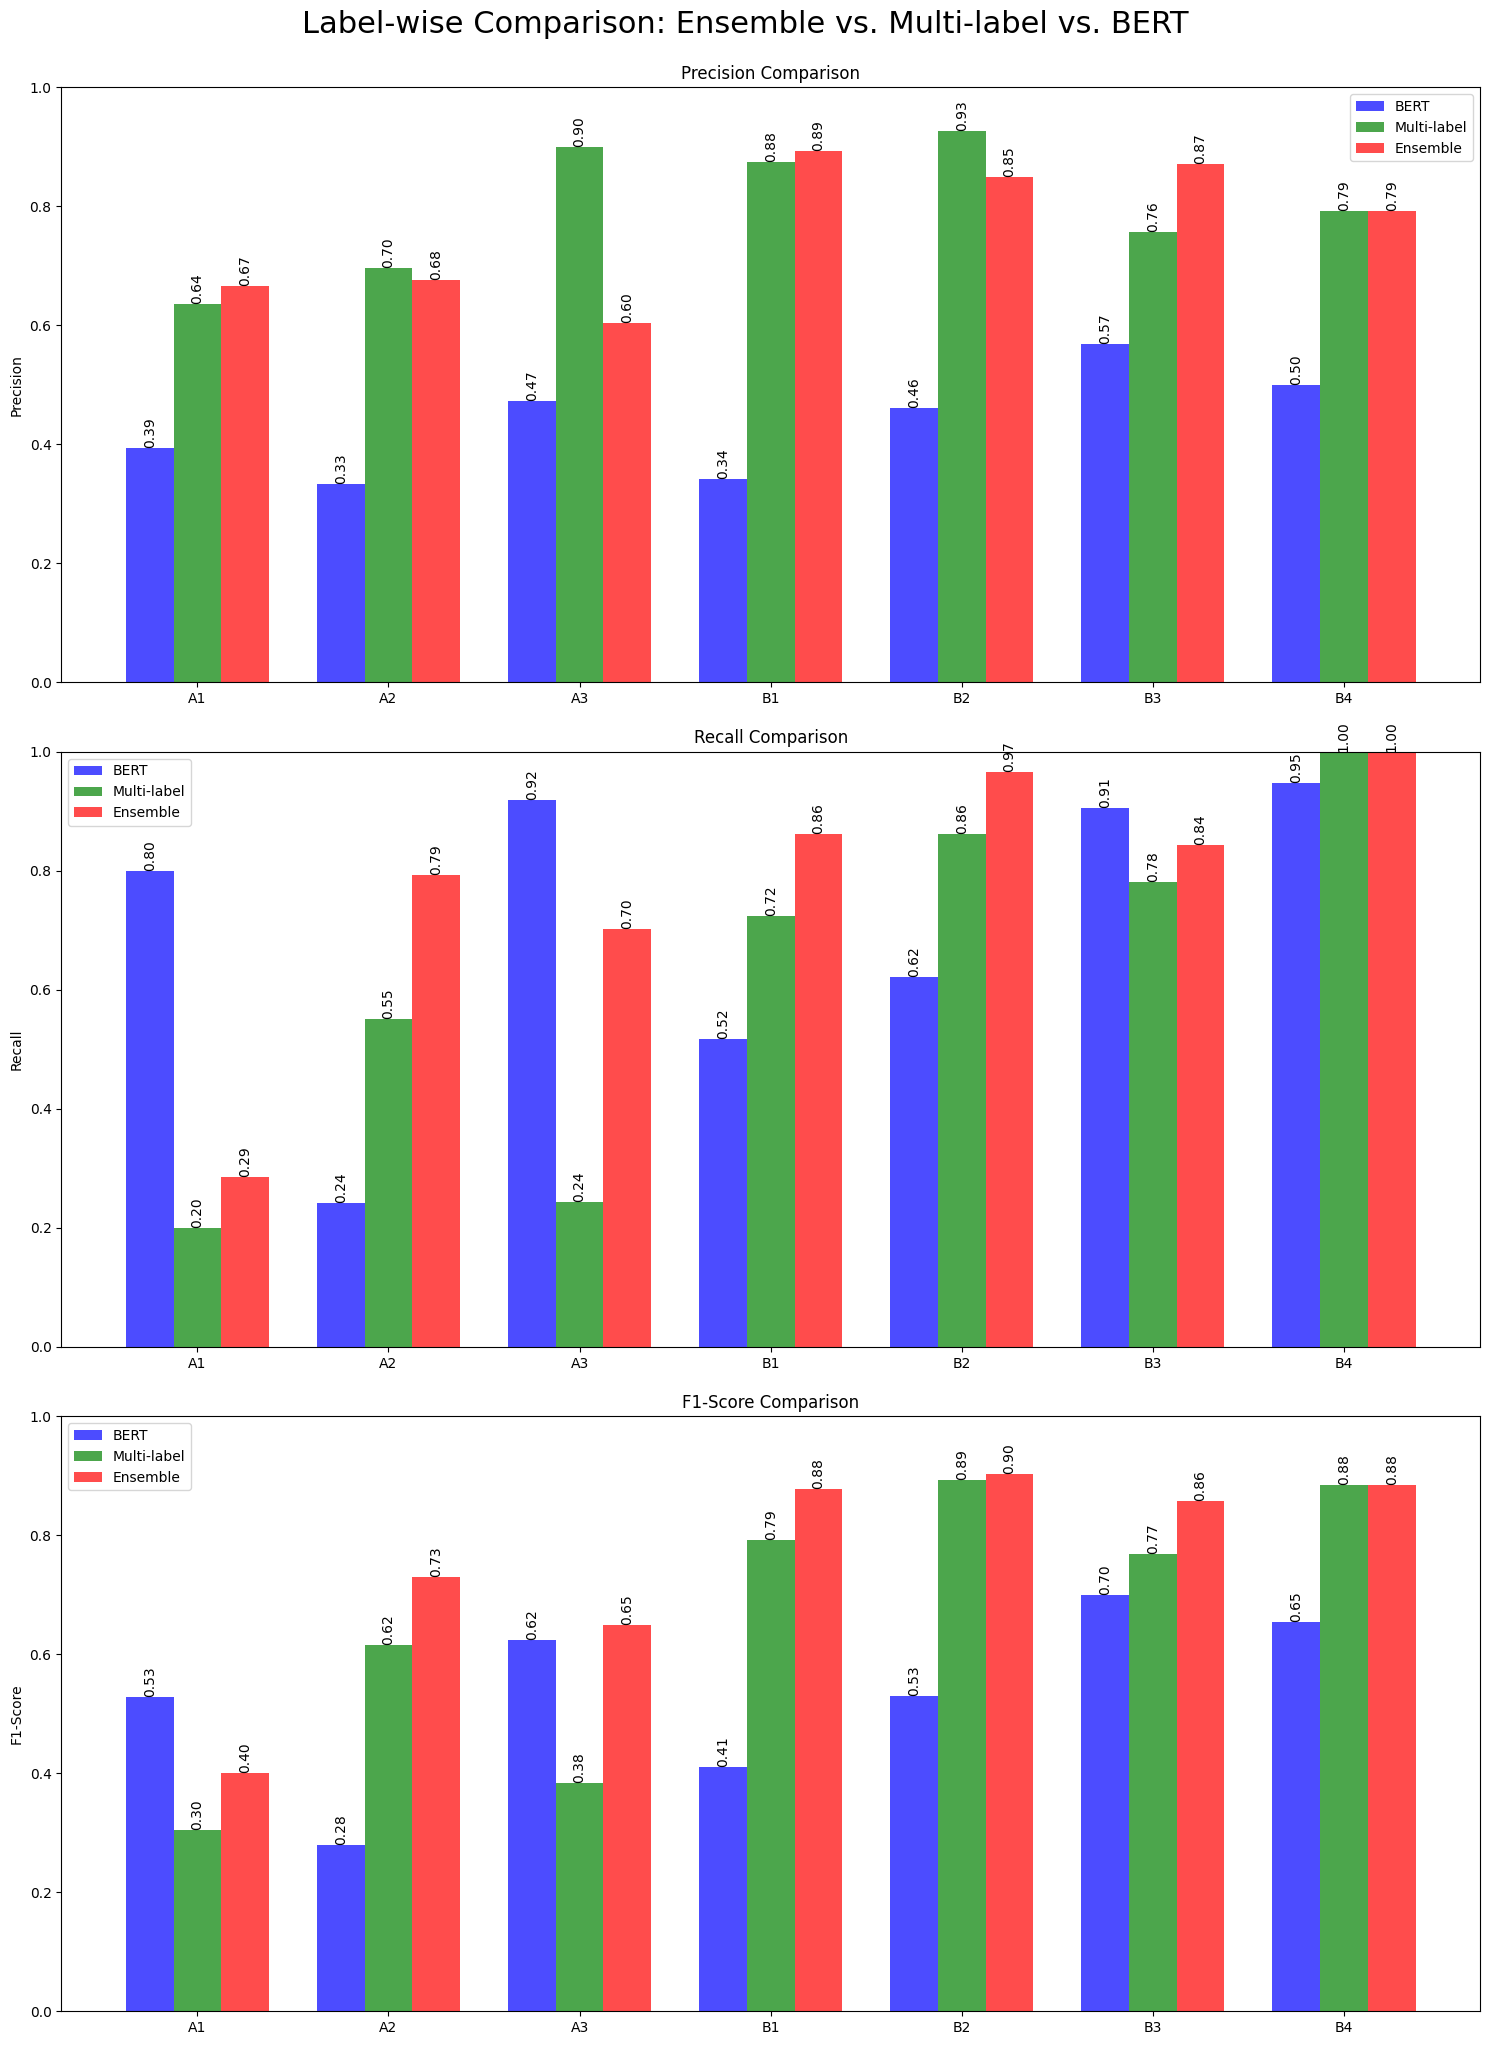

In [180]:
# load csv data from respective directories
bert_data = pd.read_csv('./subtask_3/multi_label_bert_metrics.csv')
multi_label_data = pd.read_csv('multi_label_metrics_report.csv')
ensemble_data = pd.read_csv('ensemble_metrics_report.csv')

# plotting images in 3 rows and 1 column in a single plot
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
metrics = ['Precision', 'Recall', 'F1-Score']
width = 0.25
x = np.arange(len(bert_data['Label']))

# run a for loop to iterate over precision, recall and f1-score
for i, metric in enumerate(metrics):
    axs[i].bar(x - width, bert_data[metric], width, label='BERT', color='blue', alpha=0.7)
    axs[i].bar(x, multi_label_data[metric], width, label='Multi-label', color='green', alpha=0.7)
    axs[i].bar(x + width, ensemble_data[metric], width, label='Ensemble', color='red', alpha=0.7)
    
    axs[i].set_ylabel(metric)
    axs[i].set_title(f'{metric} Comparison')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(bert_data['Label'])
    axs[i].legend()
    axs[i].set_ylim(0, 1)

    # Annotate each bar with respective value
    for j in range(len(x)):
        axs[i].text(x[j] - width, bert_data[metric][j], f'{bert_data[metric][j]:.2f}', ha='center', va='bottom', rotation=90)
        axs[i].text(x[j], multi_label_data[metric][j], f'{multi_label_data[metric][j]:.2f}', ha='center', va='bottom', rotation=90)
        axs[i].text(x[j] + width, ensemble_data[metric][j], f'{ensemble_data[metric][j]:.2f}', ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.suptitle('Label-wise Comparison: Ensemble vs. Multi-label vs. BERT', fontsize=22, y=1.02)
plt.show()

## Observations:

1. In general BERT performs well in Recall, especially for categories A1-A3 whereas Multi-label and Ensemble models outperform BERT in Precision and F1- scores in most categories.
2. The Ensemble model consistenlt shows high performance across all three metrics and achieves either highest or second highest scores in B1 to B4 categories
3. B1 to B4 show higher overall performance across all the models compared to A1-A3. THe gap between BERT and other models is smaller in B categories.
4. The multi-label model excels in precision and achieves highest scores in most categories.
5. The multi-label model falls behind both BERT and ensemble models and its recall values varies significantly.
6. Overall Ensemble model performs better than the rest and is consistently performing well.
